<div style="text-align:center; background-">
  <h1>Prédiction de la qualité du vin</h1>
</div>


> Dans ce notebook, nous allons chercher à prédire la qualité du vin en fonction de différentes caractéristiques.
>
> Nous allons appliquer les différentes étapes d'un projet de Machine Learning :
> * 1. Comprendre et s'approprier le jeu de données ;  
> * 2. Identifier et analyser la contribution des variables explicatives par rapport à la variable cible ;
> * 3. Préparer les données pour la modélisation ;
> * 4. Entrainer un ou plusieurs modèles avec nos données ;
> * 5. Analyser des résultats ;
> * 6. Conclure sur les limites de nos modèles.
>
> Le jeu de données que nous allons utiliser est le jeu `wine-quality-white-and-red.csv` que l'on peut trouver [ici](https://www.kaggle.com/datasets/ruthgn/wine-quality-data-set-red-white-wine).

# 1. Comprendre et s'approprier le jeu de données

In [1]:
# Import des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

In [2]:
# Lecture du fichier csv

df = pd.read_csv('wine-quality-white-and-red.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
# Afficher la taille et la liste des variables

display(df.shape)
df.columns

(6497, 13)

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [4]:
# Afficher le type des données

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
# Verification du nombre de valeurs manquantes

df.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# Rapide étude statistique

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
# Nombre de valeurs uniques

df.nunique()

type                      2
fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   7
dtype: int64

In [8]:
# Verification du nombre de doublons

df.duplicated().sum()

1177

> Après cette première exploration, nous remarquons plusieurs choses :
> * Notre dataset contient 6497 lignes et 13 colonnes (12 explicatives et 1 cible : la variables **quality**) ;
> * Il n'y a pas de valeurs manquantes ;
> * Les types sont bons (`object` / `float` / `int`) ;
> * Les données ont des ordres de grandeurs différents ;
> * Il y a 1177 doublons, nous allons donc les supprimer.

In [9]:
# Suppression des doublons

df = df.drop_duplicates()

# 2. Analyse des données

> Dans le but de s'approprier le jeu de données et de l'analyser, nous allons afficher quelques graphiques.

<ipython-input-10-4c5c80259252>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (quality, count) in enumerate(quality_counts.iteritems()):


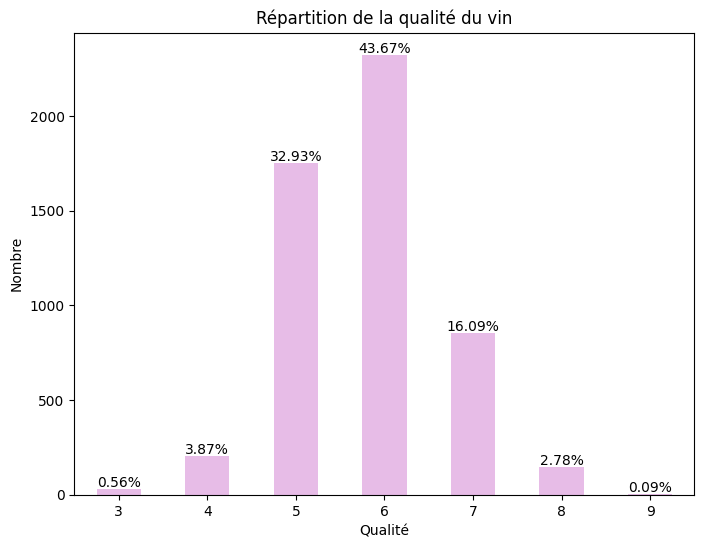

In [10]:
# Compter la répartition de la variable cible

quality_counts = df['quality'].value_counts().sort_index()

# Calculer les pourcentages

total_samples = len(df)
percentage_counts = (quality_counts / total_samples) * 100

plt.figure(figsize=(8, 6))
ax = quality_counts.plot(kind='bar', color='plum', alpha=0.7)
plt.xlabel('Qualité')
plt.ylabel('Nombre')
plt.title('Répartition de la qualité du vin')
plt.xticks(rotation=0)

# Ajouter les pourcentages au dessus de chaque colonne

for i, (quality, count) in enumerate(quality_counts.iteritems()):
    plt.text(i, count + 10, f'{percentage_counts[quality]:.2f}%', ha='center')

plt.show()

In [11]:
df['quality'].value_counts()

6    2323
5    1752
7     856
4     206
8     148
3      30
9       5
Name: quality, dtype: int64

> Notre variable cible a 7 classes : de 3 à 9 avec des données dites **déséquilibrées** :
> * Les classes 5 et 6 qui correspondent à un vin de "qualité moyenne" sont sur-représentées (32.91% et 43.65%) ;
> * Les classes 3 et 9 qui correspondent soit à un vin de très mauvaise qualité soit de très bonne qualité sont sous-représentées ( < 1%) ;
> * Il n'y a que 5 vins dans la classe 9.
>
> Notre modèle aura du mal à prédire ces classes minoritaires, surtout la classe 9, on pourra donc par la suite utiliser des **méthodes de ré-échantillonages**.

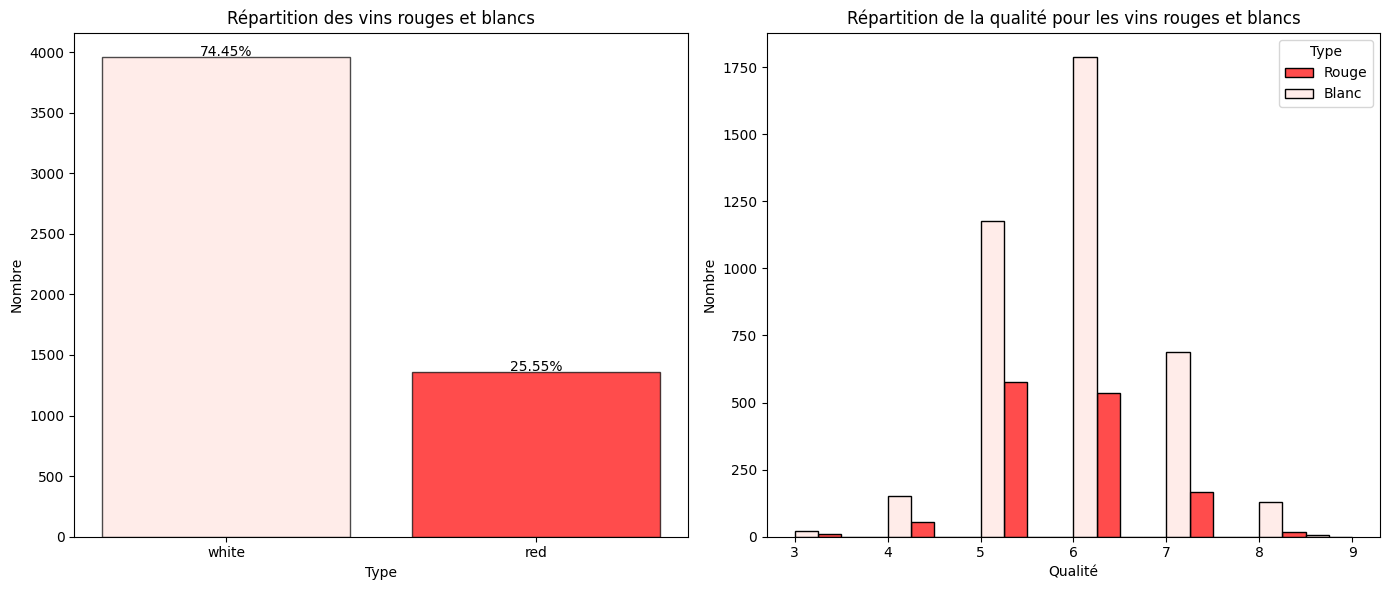

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogramme de la répartition des vins rouges et blancs

type_counts = df['type'].value_counts()
ax1.bar(type_counts.index, type_counts, color=['mistyrose', 'red'], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Type')
ax1.set_ylabel('Nombre')
ax1.set_title('Répartition des vins rouges et blancs')
ax1.set_xticks(range(len(type_counts)))
ax1.set_xticklabels(type_counts.index)

# Ajouter les pourcentages au-dessus des barres 

total_samples = len(df)
percentage_counts = (type_counts / total_samples) * 100
for i, count in enumerate(type_counts):
    ax1.text(i, count + 10, f'{percentage_counts[i]:.2f}%', ha='center')

# Graphique de répartition de la qualité pour chaque type de vin

sns.histplot(data=df, x='quality', hue='type', multiple='dodge', palette=['mistyrose', 'red'], binwidth=0.5, alpha=0.7, ax=ax2)
ax2.set_xlabel('Qualité')
ax2.set_ylabel('Nombre')
ax2.set_title('Répartition de la qualité pour les vins rouges et blancs')
ax2.legend(title='Type', labels=['Rouge', 'Blanc'])

plt.tight_layout()
plt.show()


In [13]:
# Groupement par type de vin et calcul des pourcentages de chaque qualité

percentage_by_quality = pd.crosstab(index=df['type'], columns=df['quality'], normalize='index') * 100

percentage_by_quality

quality,3,4,5,6,7,8,9
type,,,,,,,
red,0.735835,3.899926,42.457689,39.367182,12.288447,1.250920,0.000000
white,0.504923,3.862661,29.664226,45.140116,17.394597,3.307246,0.126231


> On remarque dans notre jeu de données que :
> * Il y a une proportion nettement plus élevée de vins blancs que de vins rouges, avec une répartition de 75% de vins blancs contre 25% de vins rouges ; 
> * Tant pour les vins blancs que pour les vins rouges, les classes de qualité des vins sont déséquilibrées ;
> * Il n'y a pas de vin rouge noté en classe 9, ce qui signifie que les vins rouges de très haute qualité ne sont pas représentés dans le jeu de données.
>

#### Analysons à présent les variables numériques.

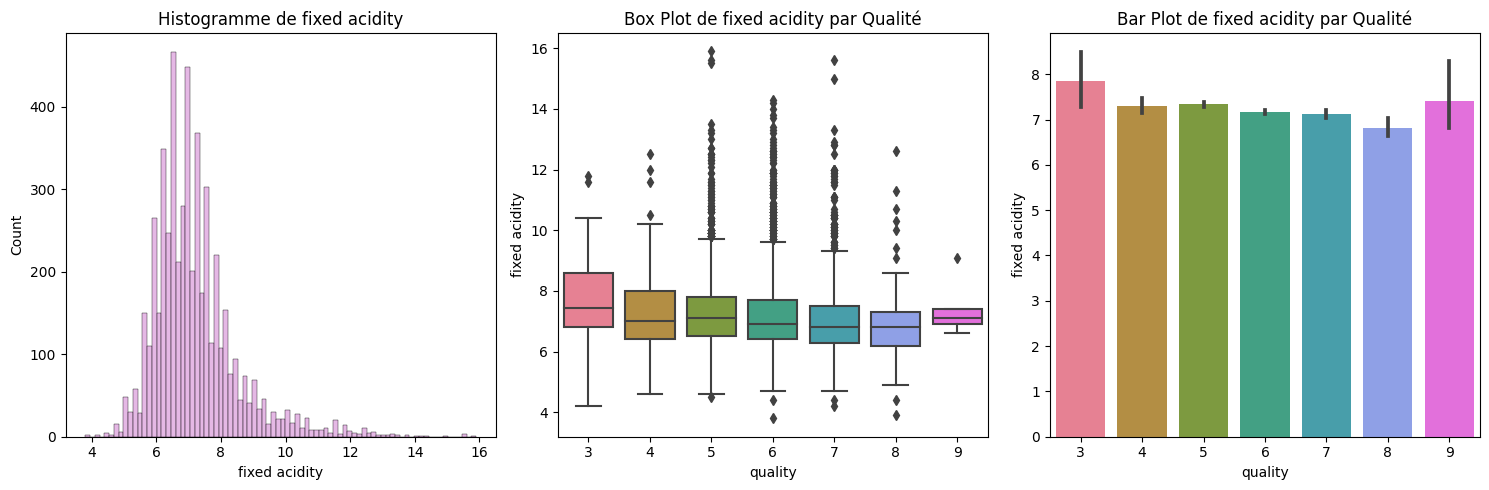

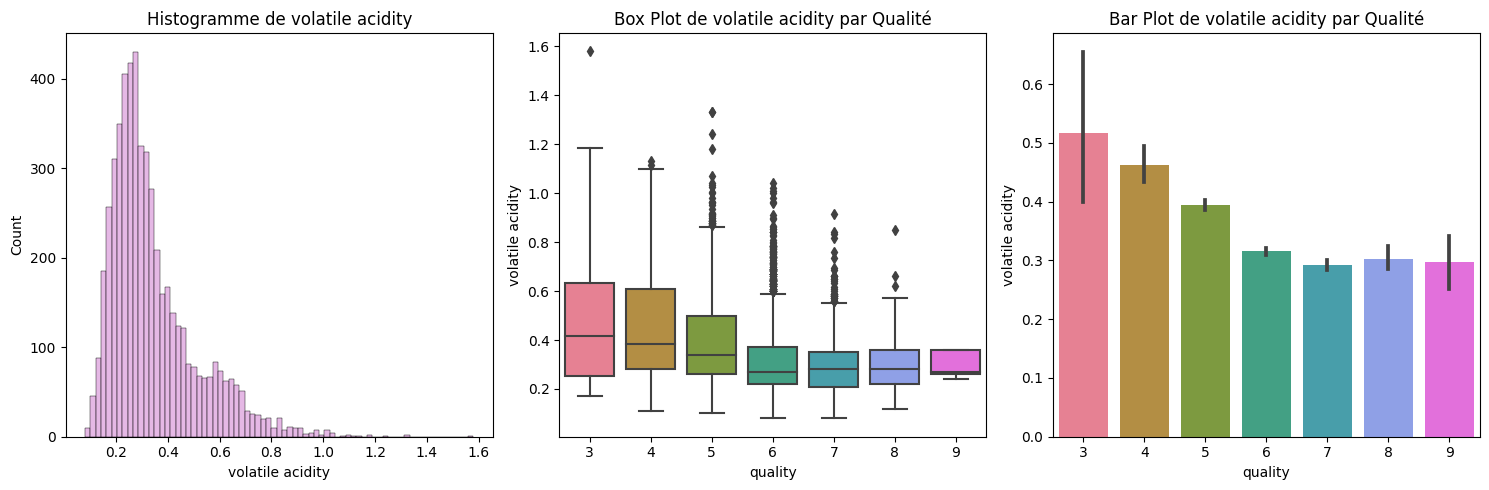

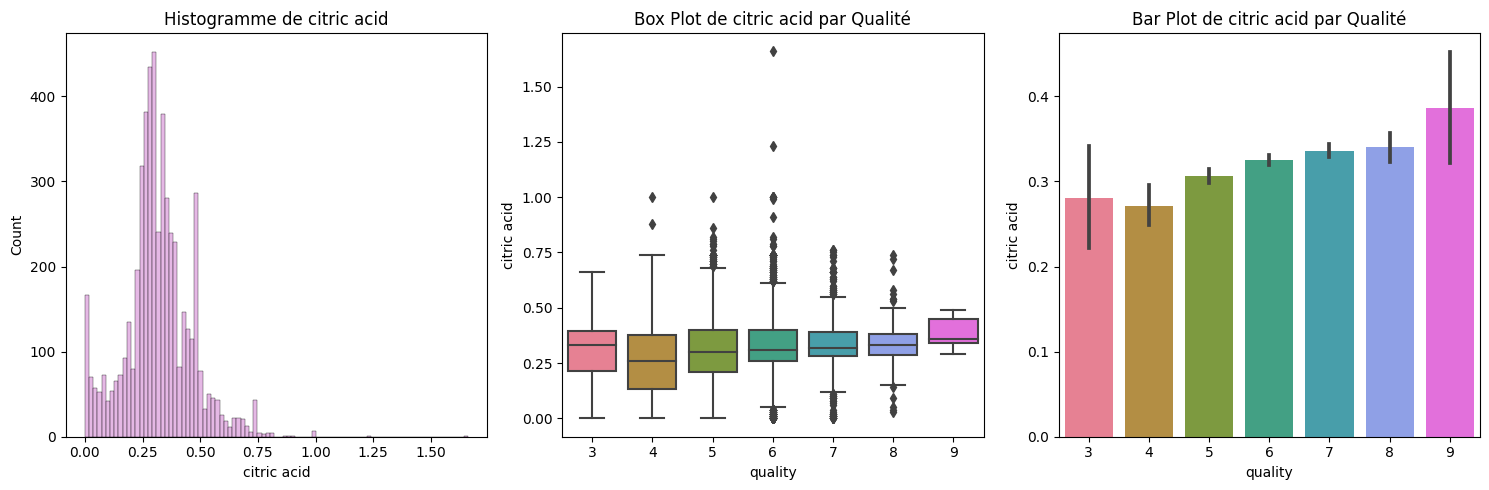

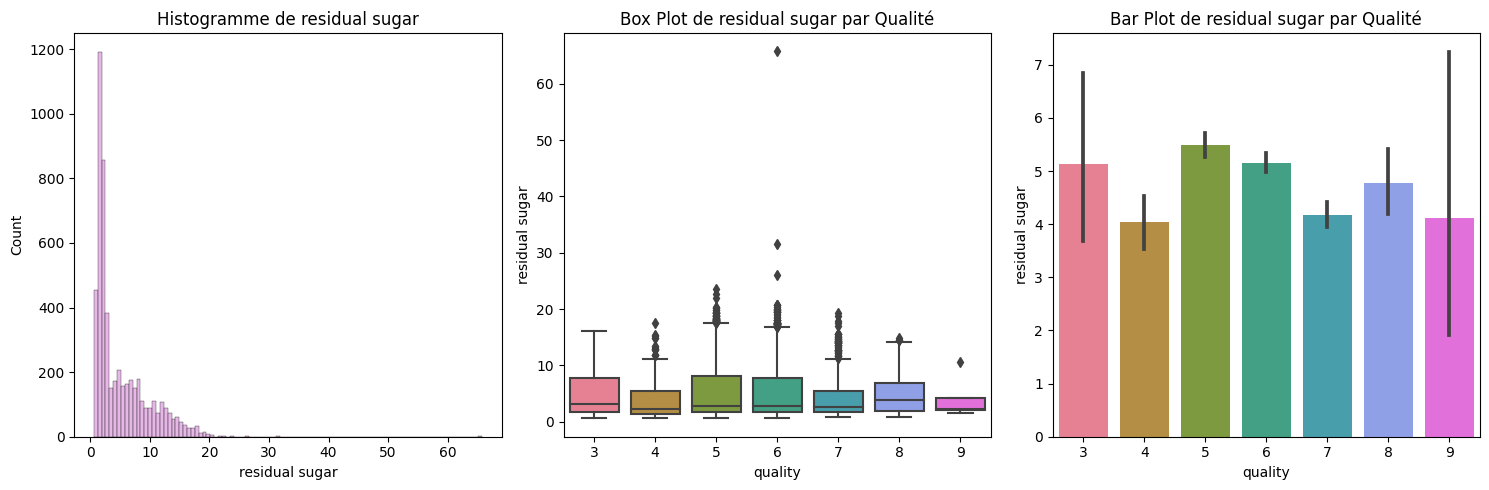

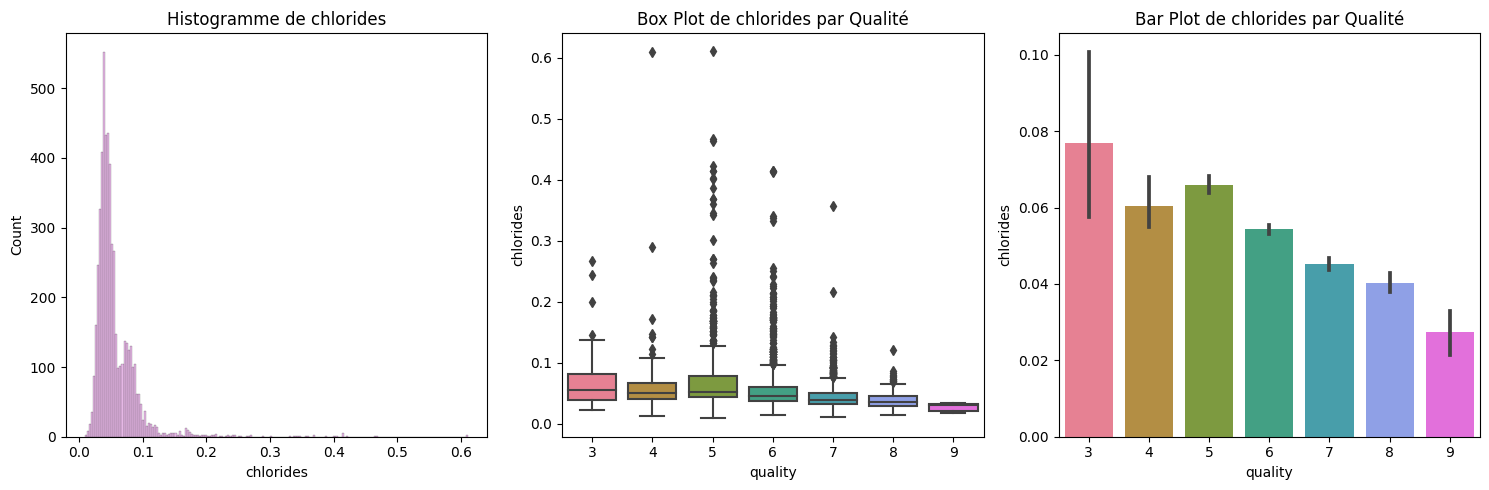

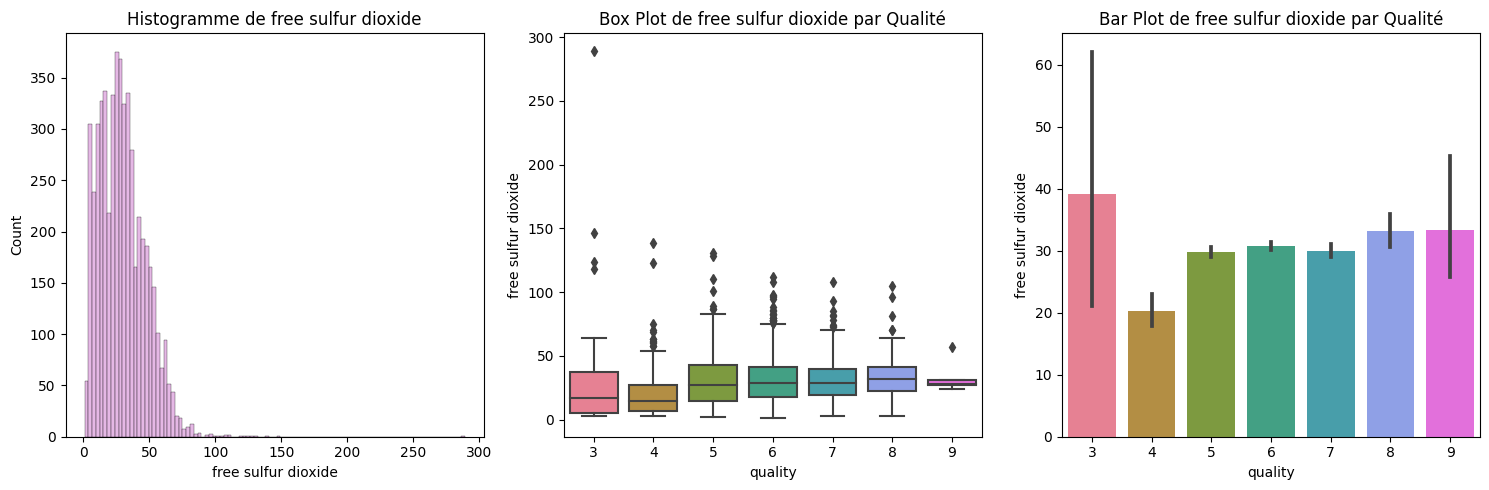

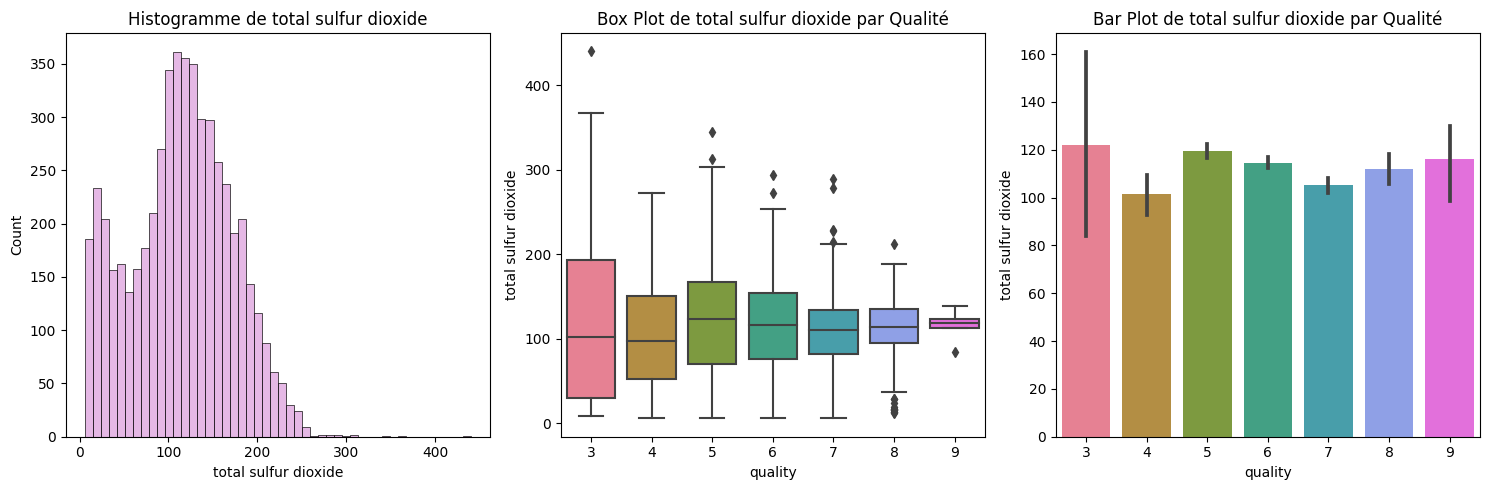

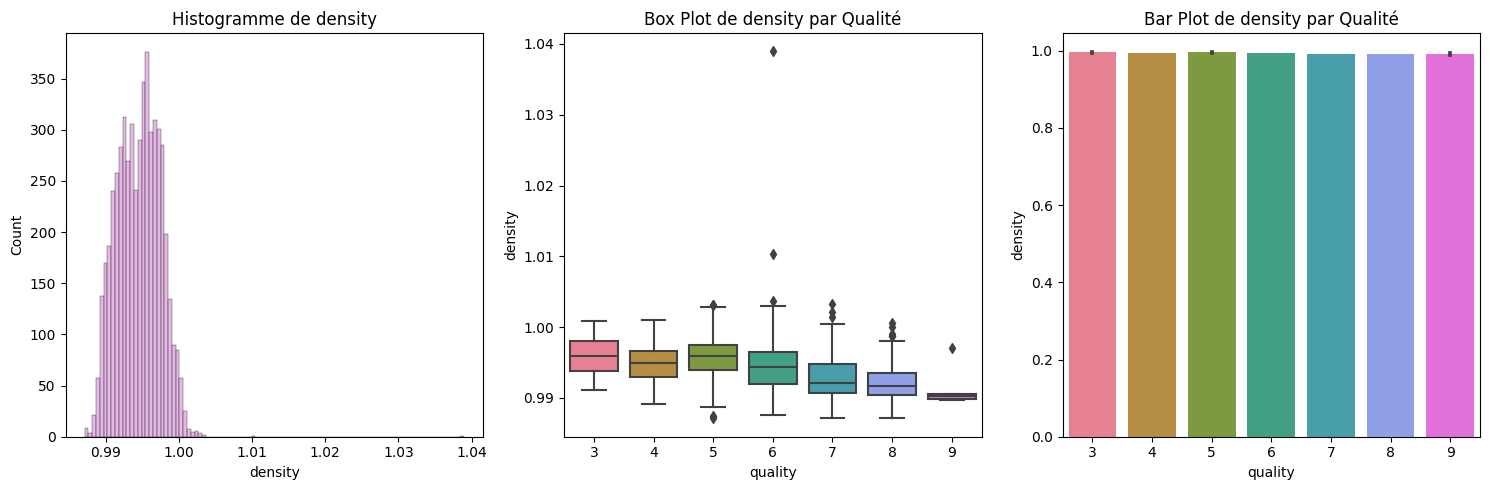

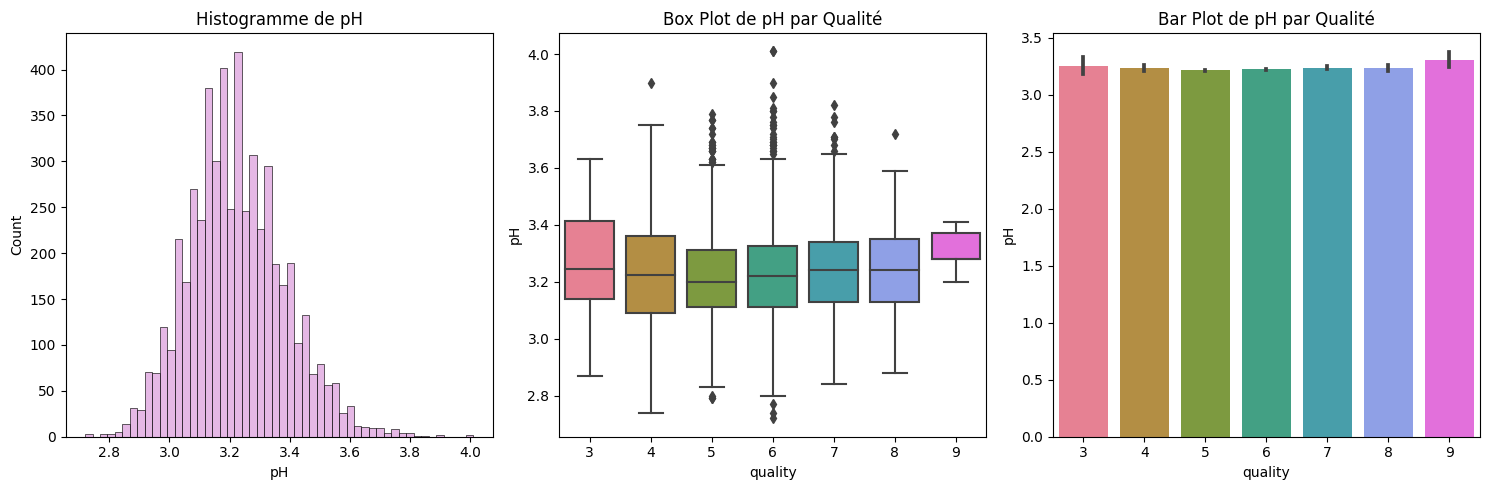

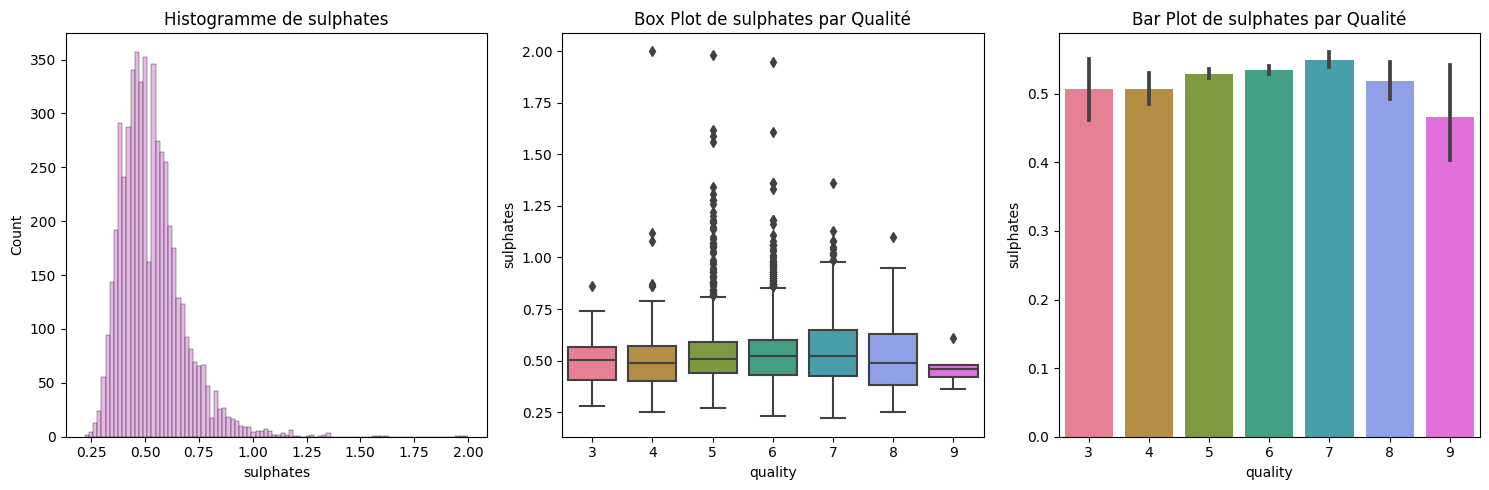

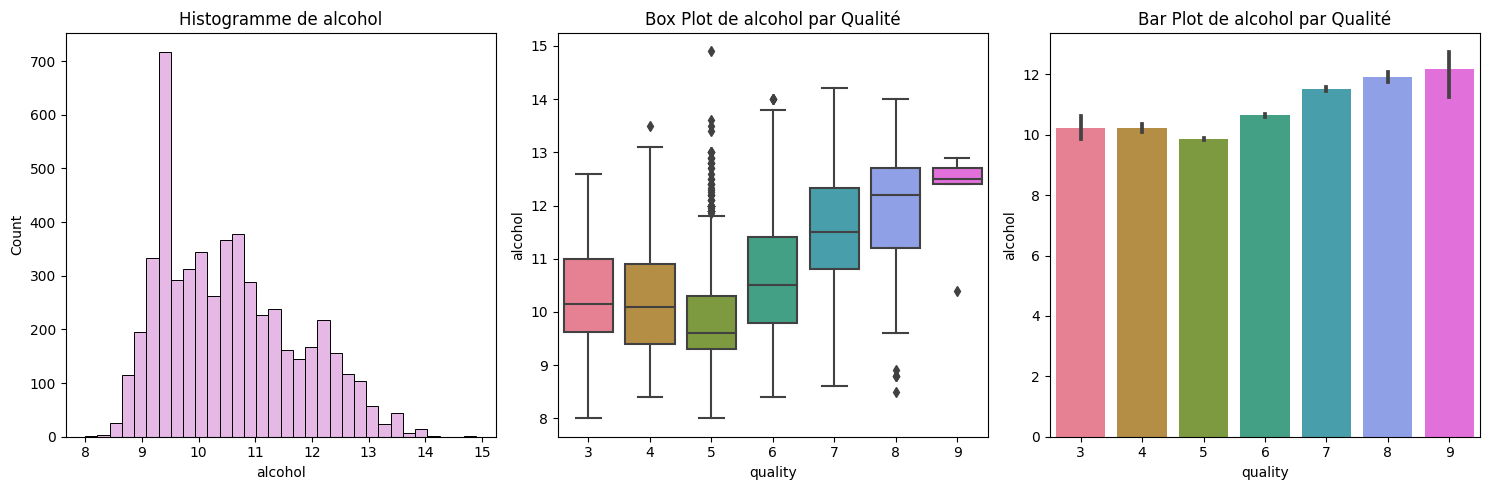

In [14]:
feature_num = df.columns[1:12]

for var in feature_num:
    plt.figure(figsize=(15, 5))

    # Histogramme
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=var, color = 'plum')
    plt.title(f'Histogramme de {var}')

    # Box Plot
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, y=var, x='quality', palette="husl")
    plt.title(f'Box Plot de {var} par Qualité')

    # Bar Plot
    plt.subplot(1, 3, 3)
    sns.barplot(x='quality', y=var, data=df, palette="husl")
    plt.title(f'Bar Plot de {var} par Qualité')

    plt.tight_layout()
    plt.show()


> Grâce à ces graphiques, nous pouvons observer les points suivants :
>
>* La variable `"volatile acidity"` présente principalement des valeurs comprises entre 0,2 et 0,4. Selon nos données, une diminution de cette valeur est associée à une meilleure qualité du vin, ce constat est également valable pour la variable `"chlorides"`; 
>* En ce qui concerne la variable `"alcohol"`, une valeur plus élevée est corrélée à une meilleure qualité du vin ;
> * Pour les autres variables explicatives, les graphiques ne montrent pas de tendance significativement différente entre les vins de bonne qualité et ceux de mauvaise qualité ; 
> * Pour les vins de qualité moyenne (5, 6 et 7), nous observons une plus grande dispersion des valeurs. Cette dispersion peut être attribuée au nombre beaucoup plus élevé d'observations dans cette catégorie ; 
> * Il est important de noter que les classes sont très déséquilibrées, ce qui signifie que les analyses doivent être interprétées avec prudence.

<ipython-input-15-9a99b2e66c77>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_mat = df.corr()


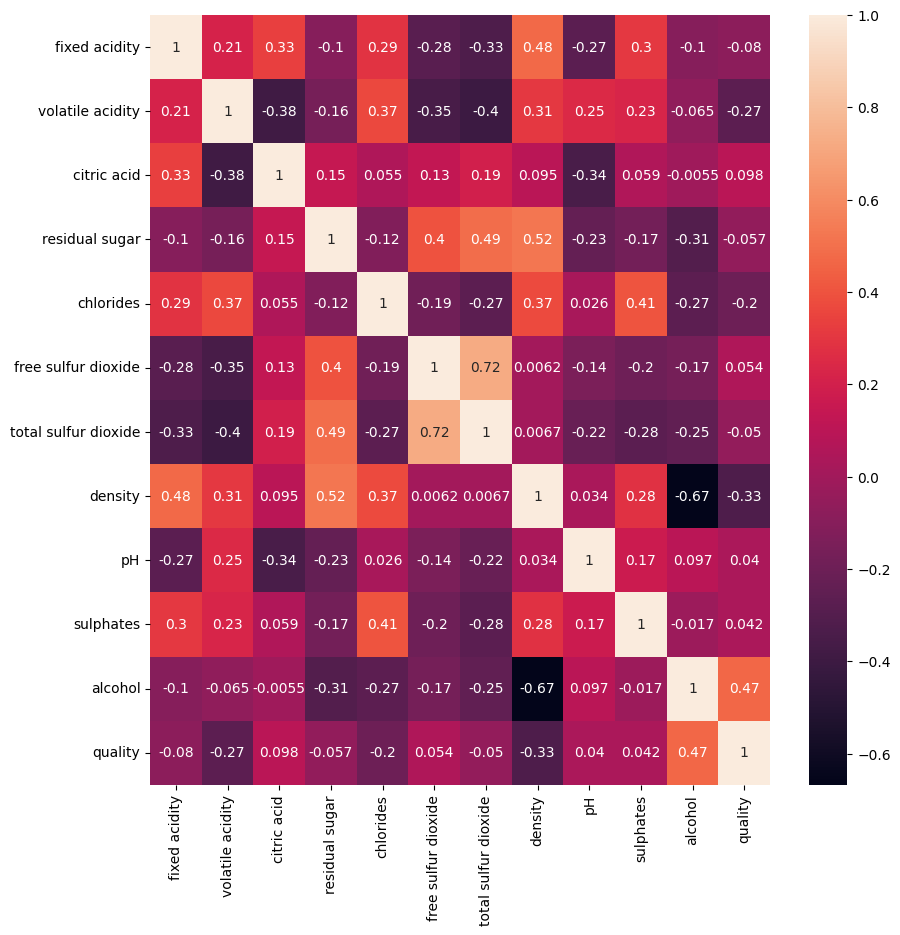

In [15]:
# matrice de corrélation

plt.figure(figsize = (10,10))
correlation_mat = df.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

<ipython-input-16-f44a4c891c95>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['quality'].abs().sort_values(ascending=False)


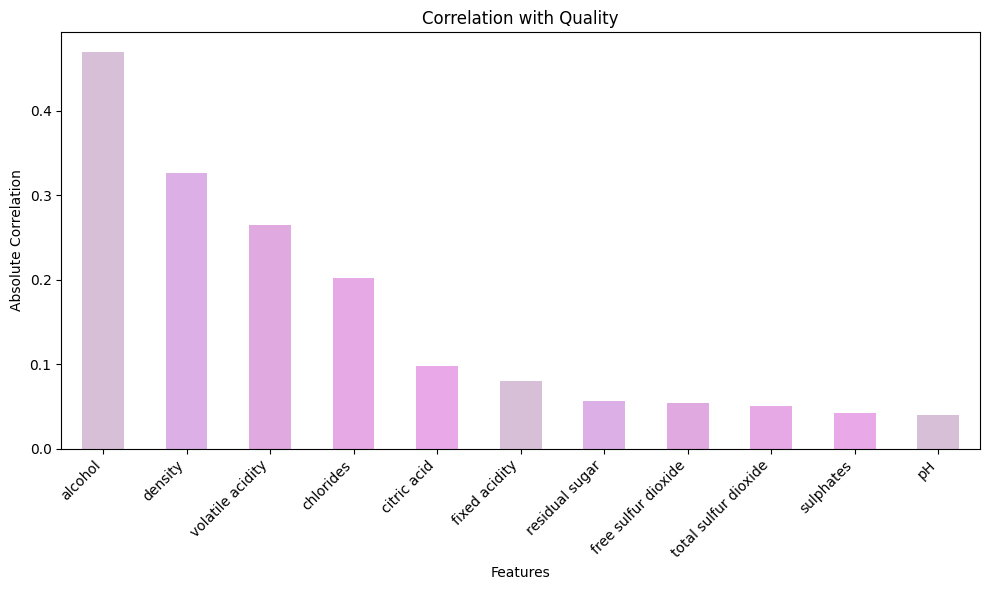

In [16]:
# Graphique des variables les plus corrélées à la varibale cible (en valeur absolue)

purple_pastel_palette = sns.color_palette(["#D8BFD8", "#DCB0E6", "#E0A9E0", "#E6A9E6", "#E9A9E9"])

correlation = df.corr()['quality'].abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlation[1:].plot(kind='bar', color=purple_pastel_palette)
plt.title('Correlation with Quality')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Analyse de la matrice de corrélation

> * Aucune des variables explicatives n'a une corrélation très élevée (> 0.7) avec la variable cible mais la plus corrélée positivement est : `alcohol`, et les plus corrélées négativement sont : `volative acidity` et `density`.
>
>On remarque également deux corrélations intéressantes :
> * Entre les variables `density` et `alcohol` (-0.69 -> corrélation négative) ;
> * Entre les variables `total sulfur dioxide` et `free sulfur dioxide` (0.72 -> corrélation positive).

# 3. Préparer les données pour la modélisation

> Avant d'entamer le processus de modélisation, nous devons procéder à trois étapes :
> 1. Encodage de la variable catégorielle (`type`) ;
> 2. Normalisation des données car elles ne sont pas à la même échelle de valeurs ;
> 3. Re-échantillonnage des données déséquilibrées.



In [17]:
df['type'] = df['type'].replace(['red', 'white'], [0,1])

X = df.drop('quality', axis = 1)

y = df['quality']

# Argument stratify = y pour conserver la répartition de la varibale cible dans le jeu d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

> Au vu de la répartition très déséquilibrées des classes, nous allons **sous-échantillonner** les classes majoritaires et **sur-échantillonner** les classes minoritaires.

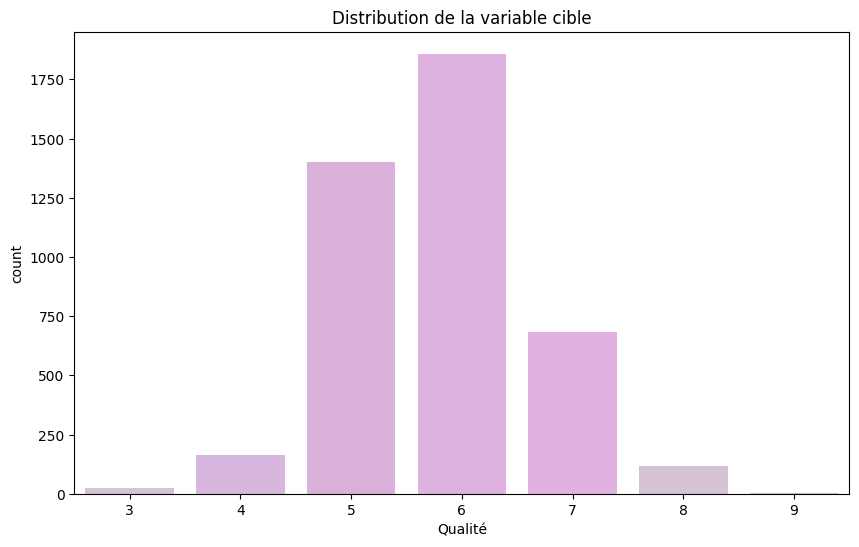

In [18]:
plt.figure(figsize = (10,6))

sns.countplot(x = y_train.values , order = [3, 4, 5, 6, 7, 8,9 ], palette =  sns.color_palette(["#D8BFD8", "#DCB0E6", "#E0A9E0", "#E6A9E6", "#E9A9E9"]))
plt.xlabel('Qualité')

plt.title('Distribution de la variable cible')

plt.show()

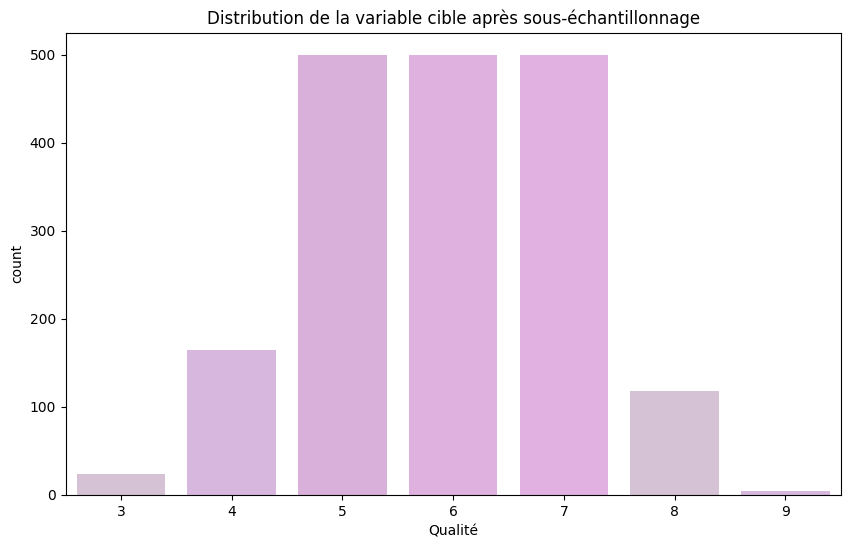

In [19]:
# Créez une instance de RandomOverSampler avec un maximum de 500 éléments par classe

rus = RandomUnderSampler( random_state=None, sampling_strategy = {5: 500, 6:500, 7 : 500 })

# Rééquilibrez les données d'entraînement

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

plt.figure(figsize = (10,6))

sns.countplot(x = y_resampled.values , order = [3, 4, 5, 6, 7, 8,9 ], palette = sns.color_palette(["#D8BFD8", "#DCB0E6", "#E0A9E0", "#E6A9E6", "#E9A9E9"]))

plt.xlabel('Qualité')

plt.title('Distribution de la variable cible après sous-échantillonnage')

plt.show()


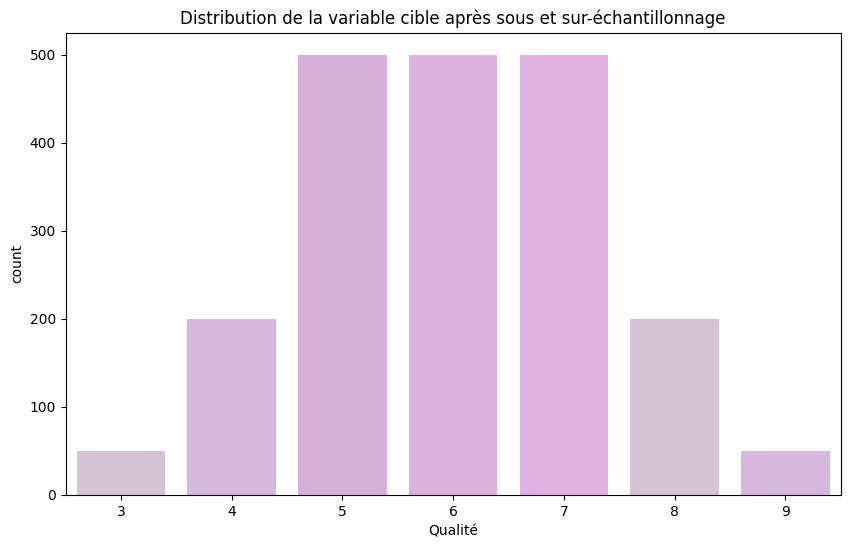

In [20]:
sm = SMOTE(k_neighbors= 3, random_state=42, sampling_strategy = {4: 200, 8:200, 3 : 50, 9 : 50 } )

X_resampled, y_resampled  = sm.fit_resample(X_resampled, y_resampled )

plt.figure(figsize = (10,6))

sns.countplot(x = y_resampled.values , order = [3, 4, 5, 6, 7, 8,9 ], palette = sns.color_palette(["#D8BFD8", "#DCB0E6", "#E0A9E0", "#E6A9E6", "#E9A9E9"]))

plt.xlabel('Qualité')

plt.title('Distribution de la variable cible après sous et sur-échantillonnage')

plt.show()

In [21]:
# Standardisation des données

scaler = MinMaxScaler()

X_resampled = scaler.fit_transform(X_resampled)

X_test = scaler.transform(X_test)

# 4. Modélisation

## Modèle basique avec 7 classes 

> Nos données sont prêtes, nous allons passer à l'entraînement du modèle. Commencons par un modèle basique pour avoir une valeur de référence. 

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciation d'un KNN
model = KNeighborsClassifier(n_neighbors = 20, weights='distance')

# Entrainement du modèle 
scr = model.fit(X_resampled, y_resampled)

# Calcul de l'accuracy
print(model.score(X_test, y_test))


0.4483082706766917


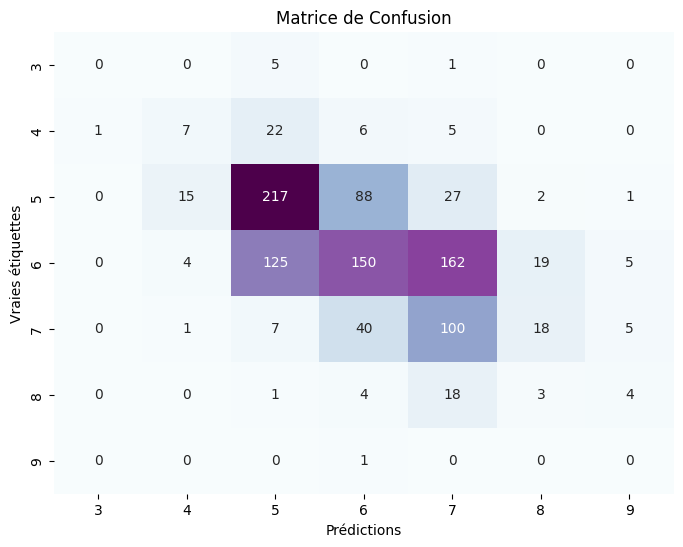

In [23]:
y_pred = model.predict(X_test)

classes = [3,4,5,6,7,8,9]

# Calcul de la matrice de confusion 
confusion = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='BuPu', cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

In [24]:
report = classification_report(y_test, y_pred)

# Afficher le rapport de classification

print(report)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.26      0.17      0.21        41
           5       0.58      0.62      0.60       350
           6       0.52      0.32      0.40       465
           7       0.32      0.58      0.41       171
           8       0.07      0.10      0.08        30
           9       0.00      0.00      0.00         1

    accuracy                           0.45      1064
   macro avg       0.25      0.26      0.24      1064
weighted avg       0.48      0.45      0.45      1064



> Avec l'entrainement d'un premier modèle basique, nous pouvons remarquer que les **classes minoritaires sont très mal prédites**.
>
> On a un **rappel** et une **précision** très faibles pour les vins de qualité 3 et 9 alors que le modèle performe mieux pour les vins de qualité 5 et 7 avec des F1 scores raisonnables.
> On remarque que le modèle se trompe beaucoup entre des classes proches par exemple entre la classe 5 et 6 ou 6 et 7.
> On a une accuracy globale à 46% ce qui est assez faible, on va essayer d'améliorer les performances de notre modèle.
>
> Nous avons également testé différents modèles de classification classique (RandomForest, Regression Logistique, ...) qui ne sont pas dans le notebook car il n'y avait pas d'amélioration des résultats. 
>
>Nous avons donc décidé de revenir sur le *pre-processing* avant de passer à des méthodes plus complexes.
> 
> * Pour l'*Oversampling*, à la place d'utiliser SMOTE, utiliser une méthode plus avancée : ADASYN qui permet de prendre en compte la distribution des classes majoritaires.
>
> * Utiliser l'argument `class_weights` dans le but de pondérer le poids des classes minoritaires.  
>
> * Supprimer la colonne `total sulfur dioxide` car elle est très corrélée à `free sulfur dioxide`.

## Modèle avancé avec 7 classes 


In [26]:
# Suppression de la colonne fortement corrélée à free sulfur dioxide
X = X.drop('total sulfur dioxide', axis = 1 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Sous - echantillonnage
rus = RandomUnderSampler(sampling_strategy = {5: 1200, 6:1200})
X_res, y_res = rus.fit_resample(X_train, y_train)

# Sur - échantillonnage 
os = ADASYN(n_neighbors= 3, sampling_strategy = {7: 1000, 4:500, 8:500, 3:150, 9:150})
X_res, y_res = os.fit_resample(X_res, y_res )
print("After resampling :")
print(y_res.value_counts())

# Poids des classes 
class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
class_weights = {i+3: weight for i, weight in enumerate(class_weights)}
print("\nClass weights :")
print(class_weights)

# Normalisation des données 
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

After resampling :
5    1200
6    1200
7     901
8     535
4     479
3     160
9     148
Name: quality, dtype: int64

Class weights :
{3: 4.1276785714285715, 4: 1.3787652848195646, 5: 0.5503571428571429, 6: 0.5503571428571429, 7: 0.7329950848263834, 8: 1.2344459279038718, 9: 4.462355212355212}


> J'utilise un modèle **XGBOOST** pour tester un modèle plus complexe que le modèle précédent.

In [27]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    scale_pos_weight=class_weights,
    eval_metric='auc'
)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

# Trouver les paramètres par validation croisée 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2)
grid_search.fit(X_res, y_res)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   1.9s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   1.9s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   2.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   3.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   4.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   2.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   4.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   5.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_e

In [28]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

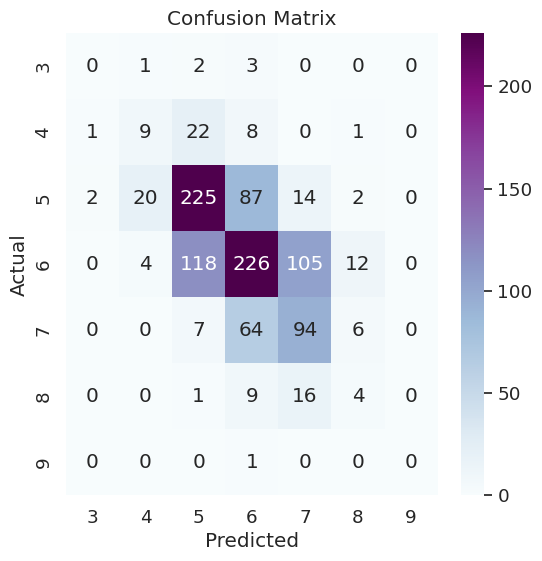

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.26      0.22      0.24        41
           5       0.60      0.64      0.62       350
           6       0.57      0.49      0.52       465
           7       0.41      0.55      0.47       171
           8       0.16      0.13      0.15        30
           9       0.00      0.00      0.00         1

    accuracy                           0.52      1064
   macro avg       0.29      0.29      0.29      1064
weighted avg       0.53      0.52      0.52      1064



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
best_estimator.fit(X_res, y_res)
y_pred = best_estimator.predict(X_test)

#Confusion matrix
class_names = ['3', '4', '5', '6', '7', '8', '9']
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

#Classification report
report = classification_report(y_test, y_pred)
print(report)

> On observe une amélioration globale par rapport au modèle précédent avec une accuracy à 51%. Cependant certaines classes (comme la classe 3) présentent toujours des performances très faibles en termes de précision (de 0), de rappel et donc de F1-score. De même pour la classe 9.
>
> On retrouve également le même problème que précédemment, le modèle se trompe entre des classes proches (par exemple entre la classe 7 et 6). Cela peut paraitre logique, car même pour un humain, il peut être compliqué de différencier un vin de classe 6 donc de moyenne/bonne qualité et un vin de classe 7 donc de plutôt bonne qualité.
>
> On choisit alors de différencier entre 5 classes plutôt que 7 classes pour simplifier la classification : very bad (classe 3), bad (classe 4 et 5),  medium (classe 6), good (classe 7 et 8) et very good (classe 9).
>

## Modèle avancé avec 5 classes 


In [30]:
df = df.drop(['total sulfur dioxide'], axis=1)

# Regroupement de classes
df['quality'] = df['quality'].replace(3, 0)
df['quality'] = df['quality'].replace([4,5], 1)
df['quality'] = df['quality'].replace(6, 2)
df['quality'] = df['quality'].replace([7,8], 3)
df['quality'] = df['quality'].replace(9, 4)

# Séparation variable cible, variables explicatives
X = df.drop('quality', axis = 1)
y  = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

y_train.value_counts()

2    1858
1    1567
3     803
0      24
4       4
Name: quality, dtype: int64

In [31]:
# Sous - échantillonnage
rus = RandomUnderSampler( random_state=None, sampling_strategy = {1: 1000, 2:1000})
X_res, y_res = rus.fit_resample(X_train, y_train)

# Sur - échantillonnage
os = ADASYN(n_neighbors= 3, random_state=42, sampling_strategy = {0:150, 4:150})
X_res, y_res = os.fit_resample(X_res, y_res )
print("After resampling :")
print(y_res.value_counts())

# Poids des classes 
class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
class_weights = {i+3: weight for i, weight in enumerate(class_weights)}
print("\nClass weights :")
print(class_weights)

#Data normalisation
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

After resampling :
1    1000
2    1000
3     803
0     160
4     148
Name: quality, dtype: int64

Class weights :
{3: 3.88875, 4: 0.6222, 5: 0.6222, 6: 0.7748443337484433, 7: 4.204054054054054}


In [32]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    scale_pos_weight=class_weights,
    eval_metric='auc'
)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2)
grid_search.fit(X_res, y_res)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   2.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_e

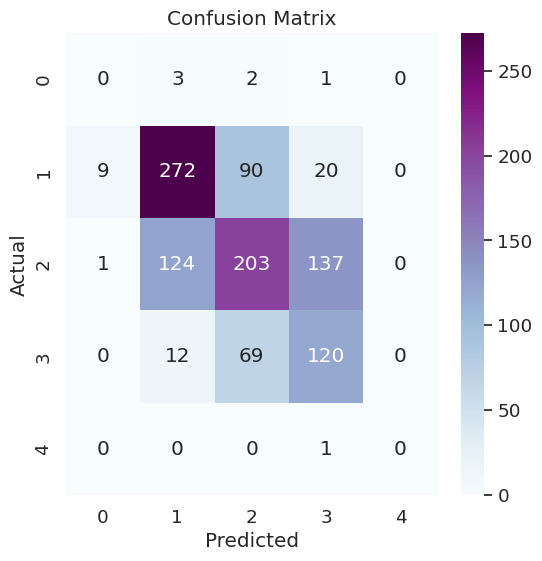

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.66      0.70      0.68       391
           2       0.56      0.44      0.49       465
           3       0.43      0.60      0.50       201
           4       0.00      0.00      0.00         1

    accuracy                           0.56      1064
   macro avg       0.33      0.35      0.33      1064
weighted avg       0.57      0.56      0.56      1064



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
best_estimator.fit(X_res, y_res)
y_pred = best_estimator.predict(X_test)

#Confusion matrix
class_names = ['0','1','2','3','4']
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

#Classification report
report = classification_report(y_test, y_pred)
print(report)

> On constate après regroupement, que le modèle a une précision globale modérée avec une accuracy à 57%. Les classes 1 et 2 montrent des performances relativement bonnes avec des scores de F1 raisonnables. Cependant, on a toujours le même problème avec les classes extrêmes/minoritaires.
>
> Nous allons à présent tester pour 3 classes bad (classes 3,4,5), medium (classes 6) et good (classes 7, 8 et 9).


## Modèle avancé avec 3 classes 



In [36]:
df = pd.read_csv('wine-quality-white-and-red.csv')
df['type'] = df['type'].replace(['red', 'white'], [0,1])
df = df.drop(['total sulfur dioxide'], axis=1)
df = df.drop_duplicates()

#merging class
df['quality'] = df['quality'].replace([3, 4, 5], 0)
df['quality'] = df['quality'].replace([6], 1)
df['quality'] = df['quality'].replace([7, 8, 9], 2)

X = df.drop('quality', axis = 1)
y  = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
y_train.value_counts()

1    1855
0    1589
2     806
Name: quality, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Sous - échantillonnage
rus = RandomUnderSampler( random_state=None, sampling_strategy = {1: 1800})
X_res, y_res = rus.fit_resample(X_train, y_train)

# Sur - échantillonnage
os = SMOTE(k_neighbors=10 , random_state=42, sampling_strategy = {0: 1600, 2:1600})
X_res, y_res = os.fit_resample(X_res, y_res )
print("After resampling :")
print(y_res.value_counts())

# Poids des classes 
class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
class_weights = {i+3: weight for i, weight in enumerate(class_weights)}
print("\nClass weights :")
print(class_weights)

# Normalisation des données 
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

After resampling :
1    1800
0    1600
2    1600
Name: quality, dtype: int64

Class weights :
{3: 1.0416666666666667, 4: 0.9259259259259259, 5: 1.0416666666666667}


In [39]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    scale_pos_weight=class_weights,
    eval_metric='auc'
)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 300]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=2)
grid_search.fit(X_res, y_res)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   2.1s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   1.5s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   1.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   1.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   2.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=300; total time=   2.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_e

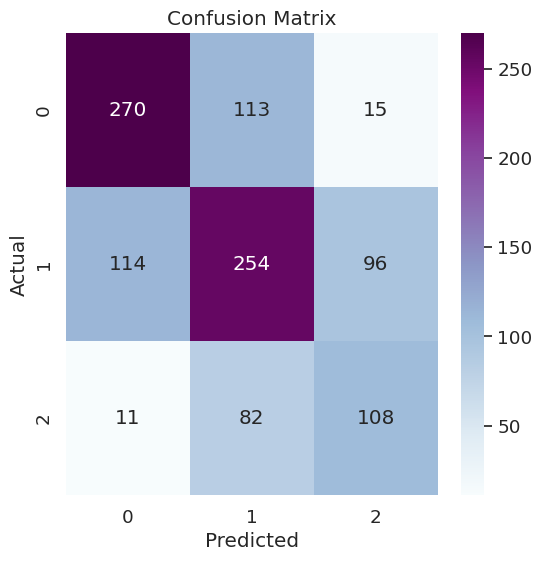

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       398
           1       0.57      0.55      0.56       464
           2       0.49      0.54      0.51       201

    accuracy                           0.59      1063
   macro avg       0.58      0.59      0.58      1063
weighted avg       0.60      0.59      0.60      1063



In [40]:
best_estimator.fit(X_res, y_res)
y_pred = best_estimator.predict(X_test)

#Confusion matrix
class_names = ['0','1','2']
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names)

#Classification report
report = classification_report(y_test, y_pred)
print(report)

> On constate que le modèle peine à différencier les classes proches (0 et 1, 1 et 2) mais qu'il différencie assez bien les classes 0 et 2.



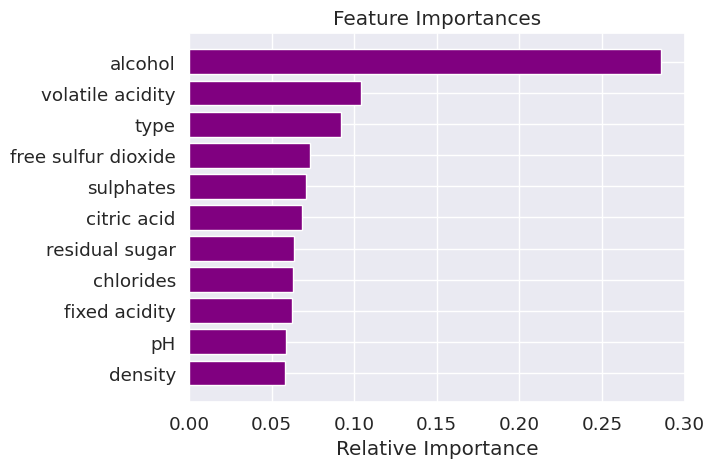

In [41]:
def plot_features_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = df.columns
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_features_importance(best_estimator)

> Pour une classification à trois classes, les trois variables qui ont le plus de poids dans le modèle sont : 
> * `alcohol`
> * `volatile acidity`
> * `type`
>
> Ceci confirme ce que nous avions analysé lors de la partie **DataViz** :
> * On observait une différence entre le taux d'alcool pour un vin de bonne qualité (forte teneur en alcool) ou de mauvaise qualité (faible teneur en alcool) ;
> * Et également une différence entre le taux "d'acidité volatile" pour un vin de bonne qualité (faible teneur en acidité volatile) et un vin de mauvaise qualité (forte teneur en acidité volatile).


# Conclusion

>Mon projet porte sur la prédiction de la qualité du vin en fonction de différentes caractéristiques. 
>
>Le principal défi auquel j'ai été confronté réside dans le déséquilibre extrême des données. Dans notre jeu de test, nous avons rencontré une situation où il y a seulement une seule observation dans la classe 9 et cinq dans la classe 3. Cela a rendu la prédiction des classes minoritaires particulièrement difficile.
>
>Pour palier à cela, nous avons appliqué des méthodes de sous-échantillonnage et de sur-échantillonnage. 
> 
>De plus, nous avons constaté que le modèle avait également du mal à distinguer les classes majoritaires, en particulier entre les classes proches. Cela peut être compréhensible, car les caractéristiques d'un vin de qualité moyenne et celles d'un vin de qualité moyenne supérieure peuvent se ressembler par exemple. Nous avons identifié ce problème dès le début grâce à l'analyse des distributions des variables explicatives en fonction de la variable cible, en effet les différences entre les données n'étaient pas très évidentes.
>
> Pour diminuer cette erreur, nous avons fusionné les classes proches entre elles en 5 classes ou en 3 classes mais cela n'a pas réellement amélioré la prédiction des classes extrêmes.  
>
